In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# This code taken from https://github.com/topipa/gp-varsel-kl-var
import GPy
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from helpers import bhattacharya, KL, get_FC_ranking, get_KL_ranking
import GP_varsel as varsel

In [4]:
funshape = "sine" #Define function shape, should be in [sine, cubic, or exp]
#funshape = "cubic"
#funshape = "exp"

all_res_final = []
for funshape in ['sine','cubic','exp']:
    #set seed
    np.random.seed(1)

    # number of repetitions to average over
    repeats = 30
    # number of covariates
    m = 8
    # number of data points
    n = 300
    # Delta for KL method
    delta = 0.0001
    nquadr = 11

    # compute the analytical scaling coefficients for the m components
    if (funshape == "sine"):
        phi = np.pi*np.linspace(0.1,1,m);
        Aunif = np.zeros(m)
        for i in range(0,m):
            Aunif[i] = np.sqrt( 4/(2 -1/phi[i]*np.sin(2*phi[i])) )

    elif (funshape == "cubic"):
        Aunif = np.zeros(m)
        for i in range(0,m):
            alpha = 1.0 - i/(m-1)
            Aunif[i] = 1.0/np.sqrt(alpha**2/3.0 + (1.0-alpha)**2/7.0 + 0.4*alpha*(1.0-alpha))

    elif (funshape == "exp"):
        Aunif = np.zeros(m)
        for i in range(0,m):
            alpha = 1.0 - i/(m-1)
            v2 = (np.exp(4) - np.exp(-4))/8 - (np.exp(2) - np.exp(-2))**2/16
            c2 = 0.5*(np.cosh(2)-0.5*np.sinh(2))
            Aunif[i] = 1.0/np.sqrt(alpha**2/3.0 + (1.0-alpha)**2*v2 + 2*c2*alpha*(1.0-alpha))

#     elif (funshape == "squared"):
#         Aunif = np.zeros(m)
#         for i in range(0,m):
#             alpha = 1.0 - i/(m-1)
#             Aunif[i] = 1.0/np.sqrt(alpha**2/3.0 + (1.0-alpha)**2/5.0 - (1.0-alpha)**2/9)

    else:
        sys.exit("unknown funshape")


    rel_ARD = np.zeros((repeats,m))
    rel_KL = np.zeros((repeats,m))
    rel_VAR = np.zeros((repeats, m))
    rel_FC = np.zeros((repeats,m))


    for i in range(0, repeats):
        print('starting repetition ', i + 1,'/',repeats)
        x = np.random.uniform(-1.,1.,(n,m))

        if (funshape == "sine"):
            phi = np.tile(np.linspace(np.pi/10,np.pi,m),(n,1))
            xphi = np.multiply(x[:,0:m],phi)
            f = np.sin(xphi)
            for j in range(0,m):
                f[:,j] = f[:,j]*Aunif[j]
        elif (funshape == "cubic"):
            f = np.zeros((n,m))
            for j in range(0,m):
                alpha = 1.0 - j/(m-1)
                f[:,j] = Aunif[j]* (alpha*x[:,j] + (1.0-alpha)*x[:,j]**3)
        elif (funshape == "exp"):
            f = np.zeros((n,m))
            for j in range(0,m):
                alpha = 1.0 - j/(m-1)
                f[:,j] = Aunif[j]* (alpha*x[:,j] + (1.0-alpha)*np.exp(2.0*x[:,j]))
        elif (funshape == "squared"):
            f = np.zeros((n,m))
            for j in range(0,m):
                alpha = 1.0 - j/(m-1)
                f[:,j] = Aunif[j]* (alpha*x[:,j] + (1.0-alpha)*(x[:,j]**2-1/3))
        #break
        # y is a sum of the m components plus Gaussian noise
        yval = f.sum(axis=1) + np.random.normal(0,0.3,(n,))
        yval = yval - np.mean(yval)
        y = np.asmatrix(yval).T

        # RBF kernel plus constant term
        kernel = GPy.kern.RBF(input_dim=m,ARD=True) + GPy.kern.Bias(input_dim=m)
        model = GPy.models.GPRegression(x,y,kernel)
        model.optimize()
        
        # ARD relevance value
        rel_ARD[i] = 1/model.sum.rbf.lengthscale

        # KL relevance value
        rel_KL[i], temp2 = get_KL_ranking(model,x,delta)
        
        # FC relevance value
        rel_FC[i], temp1 = get_FC_ranking(model,x)

        # VAR relevance value
        rel_VAR[i] = varsel.VARrel(x,model,nquadr)

    # normalize the relevance values      
    rel_ARD_nor = np.mean(rel_ARD,axis=0)
    rel_KL_nor = np.mean(rel_KL,axis=0)
    rel_FC_nor = np.mean(rel_FC,axis=0)
    rel_VAR_nor = np.mean(rel_VAR,axis=0)

    rel_ARD_nor = rel_ARD_nor/np.max(rel_ARD_nor)
    rel_KL_nor = rel_KL_nor/np.max(rel_KL_nor)
    rel_FC_nor = rel_FC_nor/np.max(rel_FC_nor)
    rel_VAR_nor = rel_VAR_nor/np.max(rel_VAR_nor)

    all_res_final.append([rel_KL, rel_FC, rel_VAR, rel_ARD])

starting repetition  1 / 30
starting repetition  2 / 30
starting repetition  3 / 30
starting repetition  4 / 30
starting repetition  5 / 30
starting repetition  6 / 30
starting repetition  7 / 30
starting repetition  8 / 30
starting repetition  9 / 30
starting repetition  10 / 30
starting repetition  11 / 30
starting repetition  12 / 30
starting repetition  13 / 30
starting repetition  14 / 30
starting repetition  15 / 30
starting repetition  16 / 30
starting repetition  17 / 30
starting repetition  18 / 30
starting repetition  19 / 30
starting repetition  20 / 30
starting repetition  21 / 30
starting repetition  22 / 30
starting repetition  23 / 30
starting repetition  24 / 30
starting repetition  25 / 30
starting repetition  26 / 30
starting repetition  27 / 30
starting repetition  28 / 30
starting repetition  29 / 30
starting repetition  30 / 30
starting repetition  1 / 30
starting repetition  2 / 30
starting repetition  3 / 30
starting repetition  4 / 30
starting repetition  5 / 30

 /Users/IsaacSebenius/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


starting repetition  29 / 30
starting repetition  30 / 30
starting repetition  1 / 30
starting repetition  2 / 30
starting repetition  3 / 30
starting repetition  4 / 30
starting repetition  5 / 30
starting repetition  6 / 30
starting repetition  7 / 30
starting repetition  8 / 30
starting repetition  9 / 30
starting repetition  10 / 30
starting repetition  11 / 30
starting repetition  12 / 30
starting repetition  13 / 30
starting repetition  14 / 30
starting repetition  15 / 30
starting repetition  16 / 30
starting repetition  17 / 30
starting repetition  18 / 30
starting repetition  19 / 30
starting repetition  20 / 30
starting repetition  21 / 30
starting repetition  22 / 30
starting repetition  23 / 30
starting repetition  24 / 30
starting repetition  25 / 30
starting repetition  26 / 30
starting repetition  27 / 30
starting repetition  28 / 30
starting repetition  29 / 30
starting repetition  30 / 30


In [8]:
rel_true = np.ones(m)
covariates = np.arange(1,m+1) 

In [9]:
plt.rcParams.update({'font.size': 21})

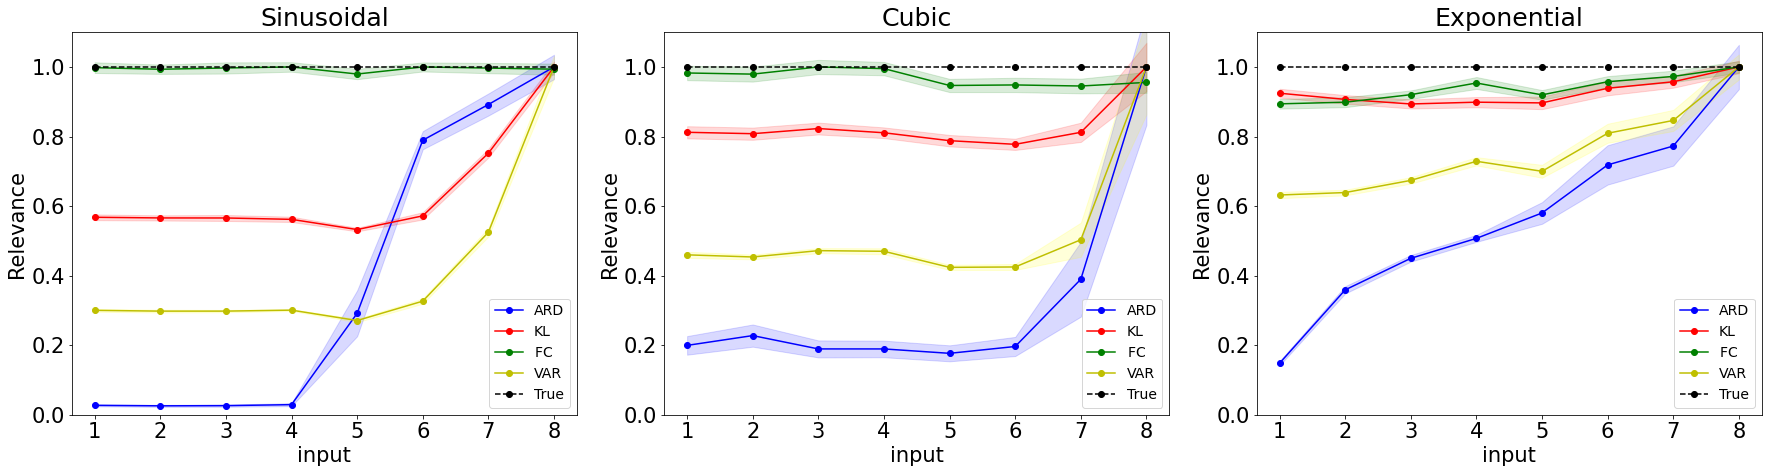

In [10]:
# plot
fig2,ax2 = plt.subplots(1,3,figsize = (25,7))

titles = ['Sinusoidal','Cubic','Exponential']
for i,q in enumerate(all_res_final):
    kl_std = np.std(q[0], axis = 0)/np.max(np.mean(q[0], axis = 0))
    kl_mean = np.mean(q[0], axis = 0)/np.max(np.mean(q[0], axis = 0))

    fc_std = np.std(q[1], axis = 0)/np.max(np.mean(q[1], axis = 0))
    fc_mean = np.mean(q[1], axis = 0)/np.max(np.mean(q[1], axis = 0))

    ard_std = np.std(q[3], axis = 0)/np.max(np.mean(q[3], axis = 0))
    ard_mean = np.mean(q[3], axis = 0)/np.max(np.mean(q[3], axis = 0))

    var_std = np.std(q[2], axis = 0)/np.max(np.mean(q[2], axis = 0))
    var_mean = np.mean(q[2], axis = 0)/np.max(np.mean(q[2], axis = 0))

    covariates = np.arange(1,m+1)

    scalar = np.sqrt(repeats)
    
    ax2[i].plot(covariates,ard_mean,'-ob',label='ARD')
    ax2[i].fill_between(covariates, ard_mean - ard_std/scalar, ard_mean + ard_std/scalar, color = 'blue', alpha = 0.15)
    
    ax2[i].plot(covariates,kl_mean,'-or',label='KL')
    ax2[i].fill_between(covariates, kl_mean - kl_std/scalar, kl_mean + kl_std/scalar, color = 'red', alpha = 0.15)
    
    ax2[i].plot(covariates,fc_mean,'-og',label='$\mathrm{FC}$')
    ax2[i].fill_between(covariates, fc_mean - fc_std/scalar, fc_mean + fc_std/scalar, color = 'green', alpha = 0.15)
    
    ax2[i].plot(covariates,var_mean,'-oy',label='VAR')
    ax2[i].fill_between(covariates, var_mean - var_std/scalar, var_mean + var_std/scalar, color = 'yellow', alpha = 0.15)

    ax2[i].plot(covariates,rel_true,'--ok',label='True')
    ax2[i].legend(prop={'size': 14})
    ax2[i].set_ylabel('Relevance')
    ax2[i].set_xlabel('input')
    ax2[i].set_title(titles[i])
    ax2[i].set_ylim(0,1.1)
    
plt.tight_layout()
plt.show()